# Hackerton 01 : Predict Future Sales    

Team Name : LeeMoonLee   
Team Nember : 이현승, 이시은, 문석빈

Period : 2021.02.09 ~ 02.10

### Preview of Project

매출액에 영향을 미치는 다양한 요소를 카테고리로 생성한 2013년 01월 부터 2015년 10월까지의 데이터를 활용하여 **2015년 11월 매출액 예측**하는 프로젝트이다.  

러시아 내의 도시별/지역별 상점에서 판매한 판매 물품별 관련 데이터로 구성되어 있고, 시계열 데이터이므로 **시기별/계절별로 상품의 판매량과 매출액이 서로 연관이 있을 것이라는 가설**을 세웠다.   

또한, 데이터를 분석하는 과정에서 전반적인 매출액이 점차 하락세를 이루고 있는 추세이고, 매년 같은 월에 해당하는 매출액이 감소하는 추세를 보였다.   

데이터에 해당하는 러시아 회사의 경우, 매년 매출액이 감소하는 이유를 파악하여 마케팅 관점 및 소비자의 성향을 파악하여 해결 방안을 만들어야 할 것으로 보인다. 더불어, 러시아 지역별/도시별 상점마다 매출액이 높은 상점을 대표적으로 남기고 매출액이 낮은 상점의 경우, 원인을 파악하여 마케팅을 진행하는 방안 및 폐점을 고려해야 할 것으로 보인다.

### Data Descriptions

- sales_train.csv - **training set.** 2013년 1월부터 2015년 10월까지의 일일 기록 데이터
- test.csv - **test set.** 2015년 11월의 주어진 데이터를 이용하여 상점의 매출을 예측
- sample_submission.csv - 제출 파일 포맷
- items.csv - 항목/제품에 대한 추가 정보
- item_categories.csv  - 항목의 범주에 대한 추가 정보
- shops.csv- 상점에 대한 추가 정보

### Data Fields

- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - 편의상 붙여진 각 월별 index. 2013년 1월은 0, 2월은 1, 2015년 10월은 33이다.
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

### Pipeline

1) 데이터 로드   
2) 데이터 전처리 및 가공     
* data preprocessing and remove outliers
* work with shops/items/categories objects and features : 컬럼명 데이터 처리
    * test dataset에서 월 매출액을 예측하기 위한 월별 매출액 dataframe 생성
* create matrix as product of item/shop pairs within each month in the train set 
* get monthly sales for each item/shop pair in the train set and merge it to the matrix : 월 별 데이터 사용을 위한 matrix 생성
* clip item_cnt_month by (0,20) : 데이터 정규화 
* append test to the matrix, fill 34 month nans with zeros
* merge shops/items/cats to the matrix
* add target lag features : 전월 매출액 features 뽑기
* add mean encoded features : 컬럼별 관계를 위한 matrix 
* add price trend features

* add month : 데이터 정규화
* add days : 데이터 정규화 
* add months since last sale/months since first sale features

* cut first year and drop columns which can not be calculated for the test set
     * 첫번째 2013년 데이터는 2012년 데이터가 없기 때문에 삭제하여 시계열 데이터 특성 고려하여 삭제

* select best features : 가장 영향을 많이 끼치는 features 채택

3) 데이터 시각화   
4) 모델 생성  
5) 모델 학습   
6) 모델 예측    

##### 필요한 모듈 import

In [2]:
import os
import pandas as pd
import numpy as np
import random as rd
import datetime
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from itertools import product
from sklearn.preprocessing import LabelEncoder # 문자를 수치로, 수치를 문자로 변환해주는 encoder
import time
import sys
import gc
import pickle
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

### 1) 데이터 로드

In [11]:
train = pd.read_csv('./data/sales_train.csv')
test = pd.read_csv('./data/test.csv')
sub = pd.read_csv('./data/sample_submission.csv')
items = pd.read_csv('./data/items.csv')
shops = pd.read_csv('./data/shops.csv')
cats= pd.read_csv('./data/item_categories.csv')

In [3]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
# date 형식 변경
# strptime(x, format) 함수는 x를 format 형식으로 parsing하여 datatime 객체로 반환
train.date = train.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))

### 2) 데이터 전처리 및 가공

### 이상치 제거

* boxplot 생성했을 때, 평균적으로 분포된 값이 아닌 데이터를 제거하거나 다른 데이터로 대체하는 방법 적용   
* 음수 및 이상치

<AxesSubplot:xlabel='item_price'>

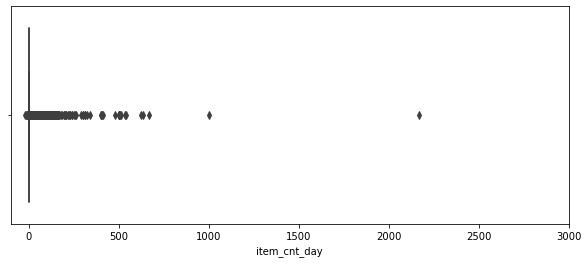

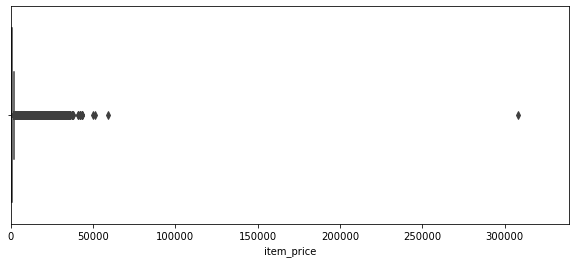

In [5]:
# item_cnt_day
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

# item_price
plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

- item_cnt_day에서 2000 근처에 있는 data는 이상치인 것으로 간주하고 삭제한다.
- item_price에서 300000만 근처에 있는 data는 이상치인 것으로 간주하고 삭제한다.

In [6]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

- item_price가 -1인 이상치를 발견하여 해당 값을 해당 날짜에 다른 지점에서 판매한 가격으로 수정하였다.

In [7]:
train.loc[(train['item_price'] < 0)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


* 음수인 이상치를 대체하기 위해 동일 shop_id / item_id 리스트를 검색하여 item_price를 파악

In [8]:
train.loc[(train['shop_id'] == 32) & (train['item_id'] == 2973)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
67427,2013-01-29,0,32,2973,2499.0,1.0
67428,2013-01-25,0,32,2973,2499.0,1.0
67429,2013-01-22,0,32,2973,2499.0,1.0
67430,2013-01-21,0,32,2973,2499.0,1.0
67431,2013-01-18,0,32,2973,2499.0,1.0
67432,2013-01-17,0,32,2973,2499.0,1.0
67433,2013-01-15,0,32,2973,2499.0,3.0
187844,2013-02-05,1,32,2973,2499.0,1.0
187845,2013-02-14,1,32,2973,2499.0,1.0
484682,2013-05-23,4,32,2973,1249.0,1.0


* 더불어, 같은 시기에 (년/월)에 해당하는 item_id를 검색하여 item_price 파악

In [9]:
train.loc[(train['date_block_num'] == 4) & (train['item_id'] == 2973)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
442065,2013-05-04,4,28,2973,2499.0,1.0
442083,2013-05-24,4,28,2973,1249.5,1.0
442084,2013-05-16,4,28,2973,1249.0,1.0
445020,2013-05-05,4,27,2973,2499.0,1.0
445021,2013-05-20,4,27,2973,1249.0,1.0
...,...,...,...,...,...,...
528018,2013-05-19,4,7,2973,1249.0,1.0
528897,2013-05-18,4,5,2973,1249.5,1.0
529456,2013-05-23,4,50,2973,1249.0,1.0
531332,2013-05-08,4,6,2973,2499.0,1.0


In [10]:
train.loc[(train['date'] == "2013-05-15") & (train['item_id'] == 2973)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
453034,2013-05-15,4,25,2973,1249.5,1.0
469026,2013-05-15,4,46,2973,1249.5,1.0
469951,2013-05-15,4,45,2973,1249.0,1.0
484683,2013-05-15,4,32,2973,-1.0,1.0


* **결론적으로, 실제 가격이 2499.0 인 상품을 할인했던 시기(50% 할인가에 판매한 것으로 가설 지정)에 1249.0 가격으로 판매했고, 동일 년/월/일 에 동일 상점/동일 아이템을 판매한 실적을 찾아 해당 가격으로 데이터 이상치를 대체한다.**

In [11]:
train.loc[train.item_price < 0, 'item_price'] = 1249.0

### 중복되는 shop_id 제거

* 동일한 도시명을 가지고 있는 shop_id 대체 

In [12]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

### shops/categories/items 전처리

* 불필요한 띄어쓰기가 되어있는 데이터 처리   
* 불필요한 부호가 들어간 데이터 처리

In [13]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск' # ! 제거
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

In [14]:
cats['split'] = cats['item_category_name'].str.split('-') # 띄어쓰기 수정
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type']) # 아이템 카테고리 이름을 숫자로 encoder (정수형)
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype']) 
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

### 월별 매출 전처리

* Test data를 활용하여 2015년 11월에 해당하는 **월별 매출액**을 예측해야 하기 때문에, 일별로 되어있는 Train data를 월별로 계산   
* data_block_num 컬럼을 활용하여 동일한 인덱스 (== 동일 년/월) 를 반복하면서 리스트 matrix 생성
* 각 진행 과정별 연산 소요 시간을 체크하기 위해 time 라이브러리 활용

In [15]:
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num == i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
# 생성한 matrix를 DataFrame화한 다음, 각 컬럼별 데이터 타입을 일정하게 변경
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts

13.548097133636475

In [16]:
matrix

,date_block_num,shop_id,item_id
114910,0,2,19
117150,0,2,27
120623,0,2,28
118316,0,2,29
114602,0,2,32
...,...,...,...
10768788,33,59,22162
10768978,33,59,22163
10769644,33,59,22164
10771170,33,59,22166


* 가격 X 일별 판매 개수 == "revenue" == 판매 금액 (매출액을 유추하기 위해 컬럼 생성)   
* 각 일별 판매량을 합해서 연산을 하고, 월별 판매량 컬럼 추가하여 데이터 처리    

* 데이터 분석을 할 때, **아이템에 해당하는 금액이 0 이하인 항목을 보고, 고객이 구매 후 환불한 항목이라고 판단하였고, 환불 금액 관련하여 어떻게 전처리를 하면 좋을지 토론을 진행**    
* 환불 금액이 언제 구매한 제품의 환불 금액인지 정확하지 않아 데이터를 제거하지 못했고, 구매금액과 환불금액이 매칭되지 않은 경우도 있어 전처리가 까다로웠다.   

* 결론적으로, 환불 금액에 대한 전처리를 따로 거치지 않고, 캐글 Data/Overview/Data evaluation에 언급된 조건에 따라 clip(0,20)으로 데이터 정규화 처리로 진행하였다.

In [17]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [18]:
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0) # 결측치 0으로 예외처리 과정 추가
                                .clip(0,20) # NB clip target here :: 0~20 사이로 데이터 정규화
                                .astype(np.float16)) # 데이터 타입 균일하게 지정

In [19]:
group

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,27,1.0
1,0,2,33,1.0
2,0,2,317,1.0
3,0,2,438,1.0
4,0,2,471,2.0
...,...,...,...,...
1609118,33,59,22087,6.0
1609119,33,59,22088,2.0
1609120,33,59,22091,1.0
1609121,33,59,22100,1.0


### Test Dataset 전처리

* Train Data에서 2015년 10월의 date_block_num이 33까지 였기 때문에, 예측해야 하는 2015년 11월 인덱스를 34로 지정   
* Test Data의 컬럼 형태 

In [20]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

* 가공한 Train Data 인 matrix와 가공한 Test Data인 test를 concat하여 Train Data에 예측해야 하는 월의 컬럼과 로우 추가

In [21]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month 모든 데이터 0으로 대체
time.time() - ts

0.11499762535095215

### shops/categories/items feature

In [22]:
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date_block_num    int8   
 1   shop_id           int8   
 2   item_id           int16  
 3   item_cnt_month    float16
 4   ID                float64
 5   city_code         int32  
 6   item_category_id  int64  
 7   type_code         int32  
 8   subtype_code      int32  
dtypes: float16(1), float64(1), int16(1), int32(3), int64(1), int8(2)
memory usage: 445.7 MB


In [23]:
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

In [24]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code
0,0,2,19,0.0,0.0,0,40,11,4
1,0,2,27,1.0,0.0,0,19,5,10
2,0,2,28,0.0,0.0,0,30,8,55
3,0,2,29,0.0,0.0,0,23,5,16
4,0,2,32,0.0,0.0,0,40,11,4
...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,214195.0,20,55,13,2
11128000,34,45,16188,0.0,214196.0,20,64,14,42
11128001,34,45,15757,0.0,214197.0,20,55,13,2
11128002,34,45,19648,0.0,214198.0,20,40,11,4


### 이전달 데이터 활용

In [25]:
# 현재 달을 기준으로 이전 n개월 만큼의 데이터를 뽑아서 해당 컬럼을 생성하고, 데이터를 구성하는 함수 정의
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

* 정의한 lag_feature 을 사용하여 1, 2, 3, 6, 12개월 전의 데이터 생성

In [26]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts

30.747471809387207

### [Data Feature 별 데이터 전처리]

* 각 컬럼별 관계를 알아보기 위해 feature 별로 계산하여 기존 Train Data인 **"matrix"**에 새로운 컬럼을 생성하여 dataframe에 축적 생성

### 월별 전체 판매 수량 평균 :: date_avg_item_cnt

* 각 월별 아이템 판매 수량을 평균을 생성하여 컬럼에 해당하는 데이터 삽입   

In [27]:
ts = time.time()
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

9.77260446548462

### 월별 아이템 판매 수량 평균 :: date_item_avg_item_cnt

In [28]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

37.52313232421875

### 월별 상점 별 아이템 판매 평균 :: date_shop_avg_item_cnt

In [29]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

38.858869552612305

### 월별 아이템 카테고리 판매 평균 :: date_cat_avg_item_cnt

In [30]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

13.578159809112549

### 월별 상점 별 판매 아이템 카테고리 평균 :: date_shop_cat_avg_item_cnt

In [31]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

13.811009883880615

### 월별 상점 코드 별 판매 아이템 평균 :: date_shop_type_avg_item_cnt

In [32]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

14.072600364685059

### 월별 상점 서브코드별 판매 아이템 평균 :: date_shop_subtype_avg_item_cnt

In [33]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

14.444271326065063

### 월별 지역별 판매 아이템 평균 :: date_city_avg_item_cnt

In [34]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

14.335026264190674

### 월별 encoder된 코드로 연산된 값 :: date_type_avg_item_cnt

In [35]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts


14.484779596328735

### 월별 encoder된 서브코드로 연산된 값 :: date_subtype_avg_item_cnt

In [36]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

14.640965938568115

### [Getting Data Flow]

### 지난 6개월간 가격 추세

In [37]:
ts = time.time()
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559
# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]
# Invalid dtype for backfill_2d [float16]

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

155.47086715698242

### 이전 달 상점 매출 추세

In [38]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts

19.05208969116211

In [39]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1
0,0,2,19,0.0,0.0,0,40,11,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
1,0,2,27,1.0,0.0,0,19,5,10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
2,0,2,28,0.0,0.0,0,30,8,55,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
3,0,2,29,0.0,0.0,0,23,5,16,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
4,0,2,32,0.0,0.0,0,40,11,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,214195.0,20,55,13,2,1.0,...,NaN,0.196899,0.126831,0.089294,0.126831,0.135376,0.146973,0.196899,-0.475098,-0.290039
11128000,34,45,16188,0.0,214196.0,20,64,14,42,0.0,...,NaN,0.155884,0.094482,0.106201,0.094482,0.135376,0.237305,0.155884,0.081116,-0.290039
11128001,34,45,15757,0.0,214197.0,20,55,13,2,0.0,...,0.181274,0.196899,0.126831,0.089294,0.126831,0.135376,0.146973,0.196899,0.155884,-0.290039
11128002,34,45,19648,0.0,214198.0,20,40,11,4,0.0,...,NaN,0.220825,0.083740,0.097046,0.083740,0.135376,0.224243,0.220825,-0.091736,-0.290039


### 고려해야 할 특징을 가지는 컬럼 데이터 처리

* 각 월별 일수가 다르기 때문에 데이터 형평성을 위해 일정하게 맞춰주는 전처리 진행    
* 해당 년/월에 처음 출시가 되어 판매가 시작된 상품이 있기 때문에 처음 판매가 시작된 것과 중간에 판매가 중지된 상품을 구분하는 컬럼 데이터 생성

In [40]:
matrix['month'] = matrix['date_block_num'] % 12

In [41]:
# 각 월별 일수
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [42]:
ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         
time.time() - ts

771.5147931575775

In [43]:
ts = time.time()
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         
time.time() - ts

541.7511274814606

### 각 상점별 첫 판매월

In [44]:
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

1.959000825881958

##### 각 컬럼별 관계를 연산한 데이터를 컬럼을 생성하여 축적시킨 최종 데이터 전처리 완료 데이터 

In [45]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
0,0,2,19,0.0,0.0,0,40,11,4,NaN,...,NaN,NaN,0.000000,NaN,0,31,-1,-1,0,0
1,0,2,27,1.0,0.0,0,19,5,10,NaN,...,NaN,NaN,0.000000,NaN,0,31,-1,-1,0,0
2,0,2,28,0.0,0.0,0,30,8,55,NaN,...,NaN,NaN,0.000000,NaN,0,31,-1,-1,0,0
3,0,2,29,0.0,0.0,0,23,5,16,NaN,...,NaN,NaN,0.000000,NaN,0,31,-1,-1,0,0
4,0,2,32,0.0,0.0,0,40,11,4,NaN,...,NaN,NaN,0.000000,NaN,0,31,-1,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,214195.0,20,55,13,2,1.0,...,0.146973,0.196899,-0.475098,-0.290039,10,30,1,-1,11,11
11128000,34,45,16188,0.0,214196.0,20,64,14,42,0.0,...,0.237305,0.155884,0.081116,-0.290039,10,30,-1,-1,2,2
11128001,34,45,15757,0.0,214197.0,20,55,13,2,0.0,...,0.146973,0.196899,0.155884,-0.290039,10,30,1,-1,34,34
11128002,34,45,19648,0.0,214198.0,20,40,11,4,0.0,...,0.224243,0.220825,-0.091736,-0.290039,10,30,-1,-1,11,11


In [46]:
ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
time.time() - ts

1.1392028331756592

### 최종 Train dataset null값 채워주기

In [47]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

0.6945309638977051

In [48]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'ID',
       'city_code', 'item_category_id', 'type_code', 'subtype_code',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
       'date_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_6', 'date_item_avg_item_cnt_lag_12',
       'date_shop_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_2',
       'date_shop_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_6',
       'date_shop_avg_item_cnt_lag_12', 'date_cat_avg_item_cnt_lag_1',
       'date_shop_cat_avg_item_cnt_lag_1', 'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_type_avg_item_cnt_lag_1', 'date_subtype_avg_item_cnt_lag_1',
       'delta_price_lag', 'delta_revenue_lag_1', 'month', 'days',
    

In [49]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 4488710 to 11128003
Data columns (total 40 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   date_block_num                        int8   
 1   shop_id                               int8   
 2   item_id                               int16  
 3   item_cnt_month                        float16
 4   ID                                    float64
 5   city_code                             int8   
 6   item_category_id                      int8   
 7   type_code                             int8   
 8   subtype_code                          int8   
 9   item_cnt_month_lag_1                  float16
 10  item_cnt_month_lag_2                  float16
 11  item_cnt_month_lag_3                  float16
 12  item_cnt_month_lag_6                  float16
 13  item_cnt_month_lag_12                 float16
 14  date_avg_item_cnt_lag_1               float16
 15  date_ite

##### 전체 과정을 반복하지 않고, 필요에 따라 사용하기 위해 따로 파일로 저장하여 Train Data 가공 완료

In [50]:
# 파일로 저장
matrix.to_pickle('data.pkl')

In [51]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
4488710,12,2,27,0.0,0.0,0,19,5,10,0.0,...,1.034180,1.075195,-0.282715,1.211914,0,31,1,1,12,12
4488711,12,2,30,0.0,0.0,0,40,11,4,0.0,...,0.270020,0.291504,-0.483398,1.211914,0,31,1,1,11,11
4488712,12,2,31,0.0,0.0,0,37,11,1,0.0,...,0.270020,0.234009,-0.137451,1.211914,0,31,1,1,11,11
4488713,12,2,32,1.0,0.0,0,40,11,4,0.0,...,0.270020,0.291504,-0.407227,1.211914,0,31,-1,1,12,12
4488714,12,2,33,1.0,0.0,0,37,11,1,1.0,...,0.270020,0.234009,-0.225464,1.211914,0,31,1,1,12,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,214195.0,20,55,13,2,1.0,...,0.146973,0.196899,-0.475098,-0.290039,10,30,1,-1,11,11
11128000,34,45,16188,0.0,214196.0,20,64,14,42,0.0,...,0.237305,0.155884,0.081116,-0.290039,10,30,-1,-1,2,2
11128001,34,45,15757,0.0,214197.0,20,55,13,2,0.0,...,0.146973,0.196899,0.155884,-0.290039,10,30,1,-1,34,34
11128002,34,45,19648,0.0,214198.0,20,40,11,4,0.0,...,0.224243,0.220825,-0.091736,-0.290039,10,30,-1,-1,11,11


In [3]:
data = pd.read_pickle('data.pkl')

In [53]:
data.loc[data['date_block_num'] == 34]

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
10913804,34,5,5037,0.0,0.0,3,19,5,10,0.0,...,0.494141,0.337402,-0.222046,-0.048553,10,30,1,1,14,14
10913805,34,5,5320,0.0,1.0,3,55,13,2,0.0,...,0.000000,0.000000,0.000000,NaN,10,30,-1,-1,0,0
10913806,34,5,5233,0.0,2.0,3,19,5,10,1.0,...,0.494141,0.337402,0.496826,-0.048553,10,30,1,1,7,7
10913807,34,5,5232,0.0,3.0,3,23,5,16,0.0,...,0.494141,0.331787,0.505371,-0.048553,10,30,1,1,3,3
10913808,34,5,5268,0.0,4.0,3,20,5,11,0.0,...,0.000000,0.000000,0.000000,NaN,10,30,-1,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,214195.0,20,55,13,2,1.0,...,0.146973,0.196899,-0.475098,-0.290039,10,30,1,-1,11,11
11128000,34,45,16188,0.0,214196.0,20,64,14,42,0.0,...,0.237305,0.155884,0.081116,-0.290039,10,30,-1,-1,2,2
11128001,34,45,15757,0.0,214197.0,20,55,13,2,0.0,...,0.146973,0.196899,0.155884,-0.290039,10,30,1,-1,34,34
11128002,34,45,19648,0.0,214198.0,20,40,11,4,0.0,...,0.224243,0.220825,-0.091736,-0.290039,10,30,-1,-1,11,11


## 3) 데이터 시각화

##### 전체 시기별 상품 판매량

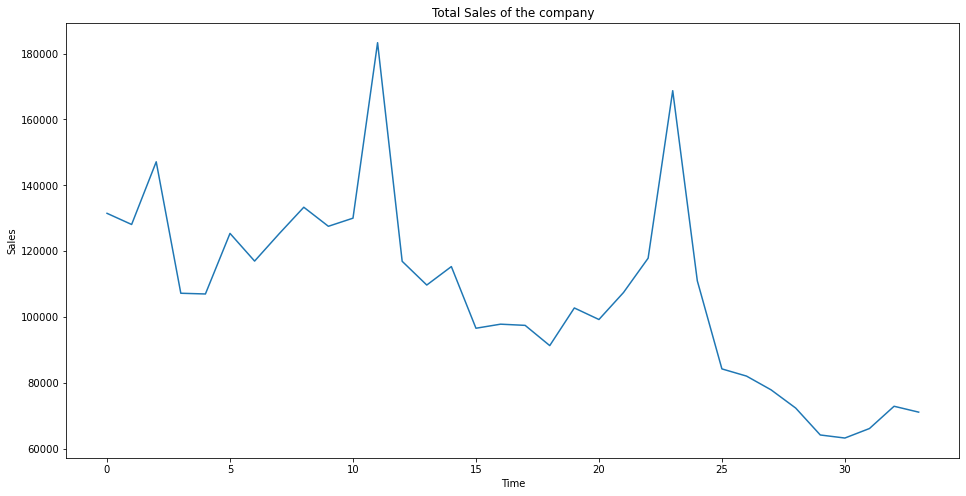

In [12]:
sell = train.groupby(["date_block_num"])["item_cnt_day"].sum()
sell.astype('float')

plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(sell);

* 판매량이 급등하는 시기가 매년 한번씩 존재하며, 전체적으로 판매량은 시간이 흐를수록 감소하는 추세를 보이고 있다.

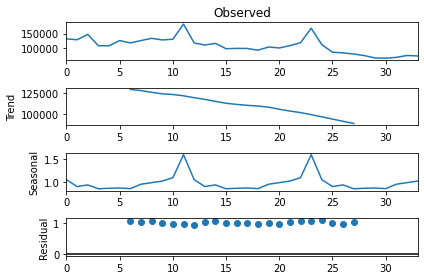

In [13]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(sell.values,freq=12,model="multiplicative")
fig = res.plot()

##### 연도별 상품 판매량     
* 상단의 전체 시기별 판매량을 연도별로 나누어 비교해 보았을 때, 연도별로 비슷한 모양의 패턴을 보이고 있는 것을 뚜렷히 알 수 있다.   
* y축의 판매량을 보았을 때, 매년 판매량이 감소하고 있는 것도 뚜렷히 알 수 있다.   
* 결론적으로, 2015년 11월의 판매량 패턴을 예측할 수 있다.

In [55]:
train013=train[train.date_block_num <=11]
train014=train.loc[(train['date_block_num'] > 11) & (train['date_block_num'] <= 23)]
train015=train[train.date_block_num >23 ]

Text(0.5, 1.0, ' 2013 Item count per day, per Month')

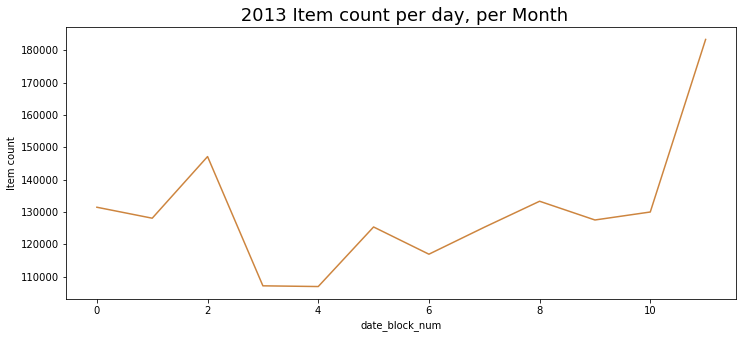

In [56]:
train013.groupby(train.date_block_num )['item_cnt_day'].sum().plot(figsize=(12, 5), color='peru')
plt.ylabel('Item count')
plt.title(" 2013 Item count per day, per Month", fontsize=18)

Text(0.5, 1.0, ' 2014 Item count per day, per Month')

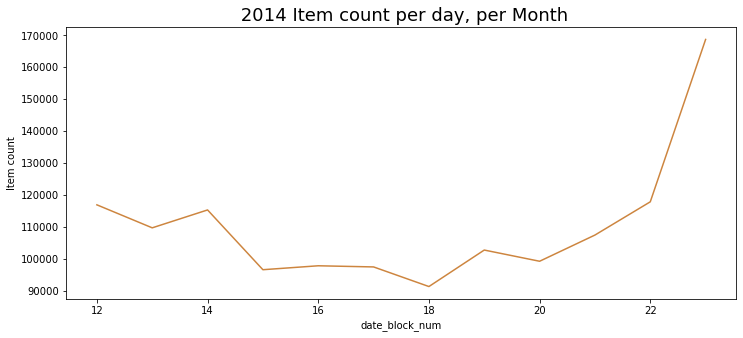

In [57]:
train014.groupby(train.date_block_num )['item_cnt_day'].sum().plot(figsize=(12, 5), color='peru')
plt.ylabel('Item count')
plt.title(" 2014 Item count per day, per Month", fontsize=18)

Text(0.5, 1.0, ' 2015 Item count per day, per Month')

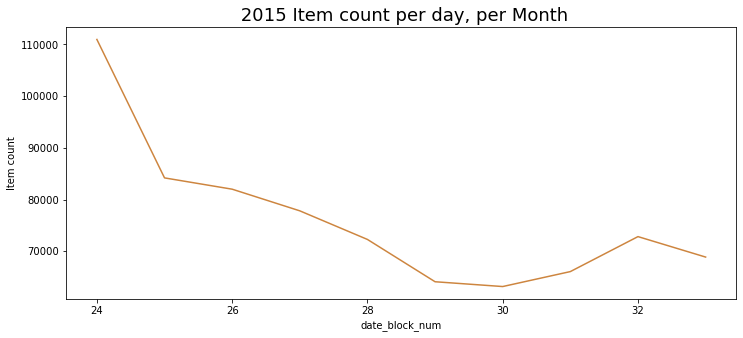

In [58]:
train015.groupby(train.date_block_num )['item_cnt_day'].sum().plot(figsize=(12, 5), color='peru')
plt.ylabel('Item count')
plt.title(" 2015 Item count per day, per Month", fontsize=18)

##### 상품 카테고리별 아이템 종류 분포 히스토그램     
* 어떠한 카테고리에 가장 많은 아이템이 분포하는지 확인하고, 해당하는 아이템 카테고리의 판매량을 비교하여 어떠한 관계를 가지는지 , 해당 카테고리가 많이 팔리는 지역 및 시기를 확인하여 해당 카테고리 상품을 추가적으로 생산하거나 개발할 수 있다.

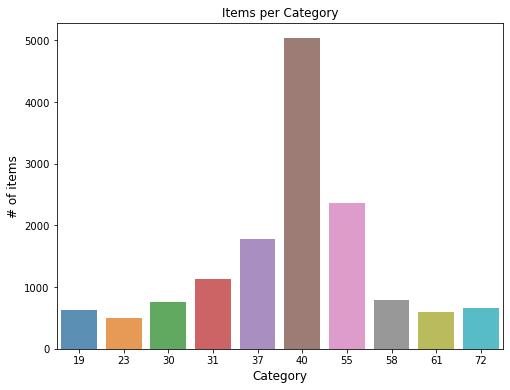

In [59]:
# number of items per cat 
x = items.groupby(['item_category_id']).count()
x = x.sort_values(by='item_id',ascending=False)
x = x.iloc[0:10].reset_index()
x

# plot
plt.figure(figsize=(8,6))
ax = sns.barplot(x.item_category_id, x.item_id, alpha=0.8) # alpha 는 투명도

plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

##### 지역코드별 판매량 비교 :: city_code    
* shop.csv 파일을 상단 데이터 전처리 과정에서 city_code로 LabelEncoder한 수치형 라벨을 활용하여 판매량 시각화 가능   
* city_code 0~30으로 총 31개의 도시로 구분되어 있음.   
* 일별 상품 판매량을 합친 월별 상품 판매량으로 구분하여 그래프 생성   

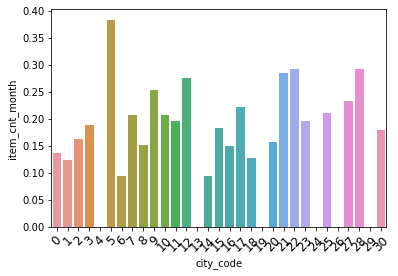

In [4]:
g = sns.barplot(data=data, x="city_code", y="item_cnt_month", ci=None)
ax = g

plt.xticks(fontsize=12, rotation=45)
plt.show()

* 가장 판매량이 많은 도시는 city_code == 5인 곳이며, 한달 판매량이 가장 많은 도시에 위치하는 상점의 분포 및 추세를 확인할 수 있을 것이며, 판매량이 없는 곳은 지역별 상점의 유무를 확인하여 추가적으로 지역의 수요가 있는지 확인 가능하다.

##### 상점별 판매량 비교 :: shop_id       
* shop.csv 파일을 상단 데이터 전처리 과정에서 shop_id 로 LabelEncoder한 수치형 라벨을 활용하여 판매량 시각화 가능

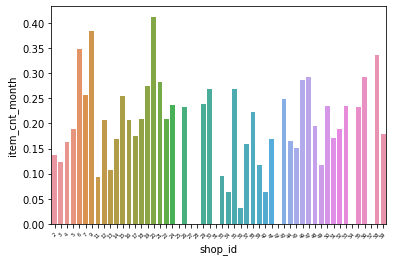

In [5]:
g = sns.barplot(data=data, x="shop_id", y="item_cnt_month", ci=None)
ax = g

#plt.figure(figsize=(30, 8))
plt.xticks(fontsize=5, rotation=45)
plt.show()

* 가장 높은 판매량을 가지는 상점은 shop_id == 20   
* 해당 상점만의 특성, 이벤트, 지역 특성, 소비자 유형을 파악하면 판매량이 높은 이유를 알 수 있다.    
* 해당 상점에서 판매량에 해당하는 아이템 분포를 알 수 있다.

## 4) 모델 생성 / 학습 / 예측

### ① Baseline Model :: XGBRegressor 

##### 모든 연산에 대하여 컬럼을 생성하여 최종 데이터를 가공했기 때문에 데이터 중 필요하지 않은 컬럼은 주석처리하여 모델 학습 진행

In [60]:
# 메모리 관리를 위해 garbage collection 진행
del matrix
gc.collect();

In [70]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    #'date_shop_avg_item_cnt_lag_1',
    #'date_shop_avg_item_cnt_lag_2',
    #'date_shop_avg_item_cnt_lag_3',
    #'date_shop_avg_item_cnt_lag_6',
    #'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    #'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    #'date_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale'
]]

* 최종 train data에 포함되어 있는 '34'(test로 예측해야 하는 년/월)와 시계열 데이터의 특성 상 33~34의 흐름을 알아야 하기 때문에 이는 Validation data로 활용    
* train은 33까지 분리하고, 33데이터는 Validation 으로 활용하여 test 데이터를 입력했을 때 예측할 수 있도록 함.

In [71]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

##### 모델 생성 및 학습 진행 :: XGBRegressor 사용

In [72]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[0]	validation_0-rmse:1.05240	validation_1-rmse:1.04130
[1]	validation_0-rmse:0.96568	validation_1-rmse:0.97828
[2]	validation_0-rmse:0.91817	validation_1-rmse:0.94986
[3]	validation_0-rmse:0.89045	validation_1-rmse:0.93582
[4]	validation_0-rmse:0.87443	validation_1-rmse:0.92775
[5]	validation_0-rmse:0.86316	validation_1-rmse:0.92396
[6]	validation_0-rmse:0.85484	validation_1-rmse:0.92180
[7]	validation_0-rmse:0.84897	validation_1-rmse:0.91745
[8]	validation_0-rmse:0.84439	validation_1-rmse:0.91732
[9]	validation_0-rmse:0.84011	validation_1-rmse:0.91497
[10]	validation_0-rmse:0.83758	validation_1-rmse:0.91502
[11]	validation_0-rmse:0.83416	validation_1-rmse:0.91357
[12]	validation_0-rmse:0.83222	validation_1-rmse:0.91286
[13]	validation_0-rmse:0.82930	validation_1-rmse:0.91140
[14]	validation_0-rmse:0.82790	validation_1-rmse:0.91147
[15]	validation_0-rmse:0.82675	validation_1-rmse:0.91096
[16]	validation_0-rmse:0.82530	validation_1-rmse:0.91176
[17]	validation_0-rmse:0.82254	validation

117.54389953613281

##### 모델 예측

In [73]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission_RMSE_90732.csv', index=False)

##### 모델을 학습하면서 데이터 간의 가양 영향을 많이 미친 컬럼(특징)을 순서대로 시각화 해주는 함수 정의

In [74]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

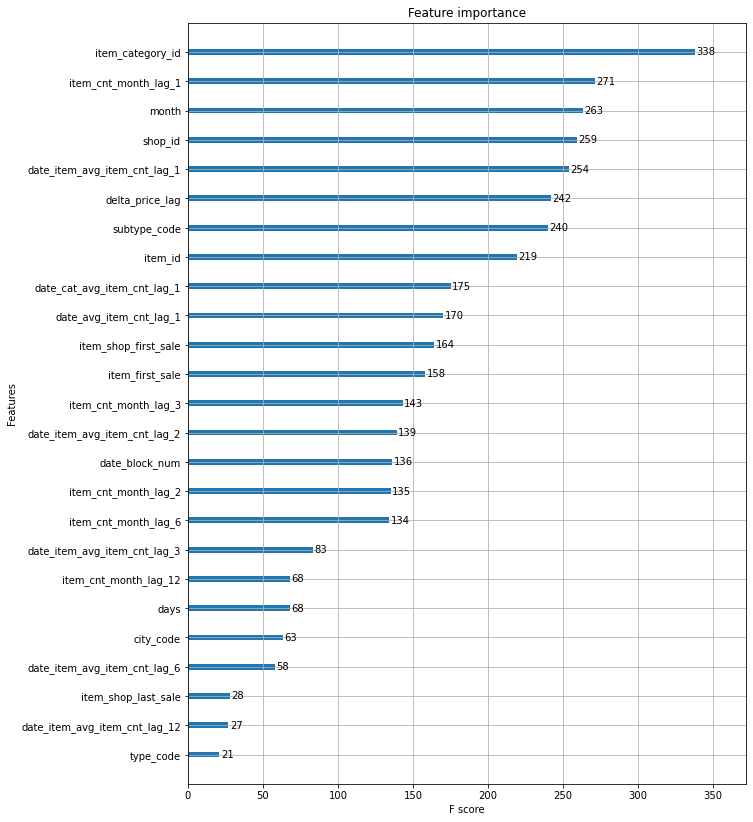

In [75]:
plot_features(model, (10,14))

##### 최종 예측 결과 저장

In [76]:
# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train_90732.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test_90732.pickle', 'wb'))

### Optuna를 이용한 Hyperparameter 최적화

In [80]:
import optuna
from sklearn.metrics import mean_squared_error

In [78]:
def objective(trial):
    
    data = pd.read_pickle('data.pkl')
    
    train_x = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
    train_y = data[data.date_block_num < 33]['item_cnt_month']
    test_x = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
    test_y = data[data.date_block_num == 33]['item_cnt_month']
    
    
    # To select which parameters to optimize, please look at the XGBoost documentation:
    # https://xgboost.readthedocs.io/en/latest/parameter.html
    param = {
        'tree_method':'gpu_hist',  # Use GPU acceleration
        'lambda': trial.suggest_loguniform(
            'lambda', 1e-3, 10.0
        ),
        'alpha': trial.suggest_loguniform(
            'alpha', 1e-3, 10.0
        ),
        'colsample_bytree': trial.suggest_categorical(
            'colsample_bytree', [0.5,0.6,0.7,0.8,0.9,1.0]
        ),
        'subsample': trial.suggest_categorical(
            'subsample', [0.6,0.7,0.8,1.0]
        ),
        'learning_rate': trial.suggest_categorical(
            'learning_rate', [0.018, 0.02, 0.021, 0.023, 0.025, 0.027]
        ),
        'n_estimators': trial.suggest_categorical(
            "n_estimators", [400, 600, 800, 1000, 1200, 1600]
        ),
        'max_depth': trial.suggest_categorical(
            'max_depth', [11,13,15,17,19]
        ),
        'random_state': 42,
        'min_child_weight': trial.suggest_int(
            'min_child_weight', 1, 300
        ),
    }
    model = XGBRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(test_x)
    
    rmse = mean_squared_error(test_y, preds,squared=False)
    
    return rmse


In [81]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2021-02-10 11:03:04,793] A new study created in memory with name: no-name-4d09776a-0fae-4914-a53b-c3fe50aa700f
[I 2021-02-10 11:05:01,272] Trial 0 finished with value: 0.8895706534385681 and parameters: {'lambda': 0.00783766714751088, 'alpha': 0.020628036007110023, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.023, 'n_estimators': 400, 'max_depth': 17, 'min_child_weight': 216}. Best is trial 0 with value: 0.8895706534385681.
[I 2021-02-10 11:12:30,295] Trial 1 finished with value: 0.9026198983192444 and parameters: {'lambda': 0.19268190754733022, 'alpha': 0.16464351415512204, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.018, 'n_estimators': 600, 'max_depth': 17, 'min_child_weight': 7}. Best is trial 0 with value: 0.8895706534385681.
[I 2021-02-10 11:13:42,428] Trial 2 finished with value: 0.8986179828643799 and parameters: {'lambda': 9.567894462550752, 'alpha': 0.007014754541677076, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.02, 'n

Number of finished trials: 10
Best trial: {'lambda': 0.00783766714751088, 'alpha': 0.020628036007110023, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.023, 'n_estimators': 400, 'max_depth': 17, 'min_child_weight': 216}


In [82]:
study.trials_dataframe().sort_values(['value'])

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_colsample_bytree,params_lambda,params_learning_rate,params_max_depth,params_min_child_weight,params_n_estimators,params_subsample,state
0,0,0.889571,2021-02-10 11:03:04.794150,2021-02-10 11:05:01.271525,0 days 00:01:56.477375,0.020628,0.5,0.007838,0.023,17,216,400,0.7,COMPLETE
5,5,0.895439,2021-02-10 11:15:37.258463,2021-02-10 11:16:53.198927,0 days 00:01:15.940464,0.022450,0.7,0.001798,0.020,13,188,600,0.7,COMPLETE
7,7,0.895939,2021-02-10 11:17:39.209212,2021-02-10 11:18:39.602114,0 days 00:01:00.392902,0.019215,0.5,0.210926,0.018,11,88,600,1.0,COMPLETE
6,6,0.897002,2021-02-10 11:16:53.199929,2021-02-10 11:17:39.208210,0 days 00:00:46.008281,0.001491,0.9,0.005954,0.025,11,225,1000,0.8,COMPLETE
4,4,0.897444,2021-02-10 11:14:27.749199,2021-02-10 11:15:37.257459,0 days 00:01:09.508260,0.004653,0.7,0.004955,0.018,13,132,600,0.6,COMPLETE
2,2,0.898618,2021-02-10 11:12:30.296177,2021-02-10 11:13:42.428617,0 days 00:01:12.132440,0.007015,0.7,9.567894,0.020,13,194,1200,1.0,COMPLETE
9,9,0.899738,2021-02-10 11:19:30.273110,2021-02-10 11:20:19.619515,0 days 00:00:49.346405,0.645098,0.6,0.003860,0.027,11,194,1000,1.0,COMPLETE
3,3,0.900299,2021-02-10 11:13:42.429617,2021-02-10 11:14:27.748199,0 days 00:00:45.318582,0.990306,0.7,1.733566,0.027,11,80,1000,0.7,COMPLETE
1,1,0.902620,2021-02-10 11:05:01.273525,2021-02-10 11:12:30.294175,0 days 00:07:29.020650,0.164644,0.5,0.192682,0.018,17,7,600,0.7,COMPLETE
8,8,0.903032,2021-02-10 11:18:39.603113,2021-02-10 11:19:30.271110,0 days 00:00:50.667997,0.017163,1.0,0.035624,0.021,11,296,400,0.7,COMPLETE


In [83]:
study.best_params

{'lambda': 0.00783766714751088,
 'alpha': 0.020628036007110023,
 'colsample_bytree': 0.5,
 'subsample': 0.7,
 'learning_rate': 0.023,
 'n_estimators': 400,
 'max_depth': 17,
 'min_child_weight': 216}

In [84]:
best_params = study.best_params
best_params['tree_method'] = 'gpu_hist'
best_params['random_state'] = 42

clf = XGBRegressor(**(best_params))

In [85]:
clf.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

[0]	validation_0-rmse:1.19404	validation_1-rmse:1.15210
[1]	validation_0-rmse:1.18122	validation_1-rmse:1.14144
[2]	validation_0-rmse:1.16919	validation_1-rmse:1.13189
[3]	validation_0-rmse:1.15861	validation_1-rmse:1.12357
[4]	validation_0-rmse:1.14696	validation_1-rmse:1.11450
[5]	validation_0-rmse:1.13641	validation_1-rmse:1.10698
[6]	validation_0-rmse:1.12760	validation_1-rmse:1.09962
[7]	validation_0-rmse:1.11664	validation_1-rmse:1.09125
[8]	validation_0-rmse:1.10623	validation_1-rmse:1.08356
[9]	validation_0-rmse:1.09627	validation_1-rmse:1.07626
[10]	validation_0-rmse:1.08684	validation_1-rmse:1.06912
[11]	validation_0-rmse:1.07774	validation_1-rmse:1.06255
[12]	validation_0-rmse:1.06917	validation_1-rmse:1.05624
[13]	validation_0-rmse:1.06207	validation_1-rmse:1.05117
[14]	validation_0-rmse:1.05340	validation_1-rmse:1.04447
[15]	validation_0-rmse:1.04581	validation_1-rmse:1.03888
[16]	validation_0-rmse:1.03742	validation_1-rmse:1.03251
[17]	validation_0-rmse:1.03002	validation

XGBRegressor(alpha=0.020628036007110023, base_score=0.5, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             gamma=0, gpu_id=0, importance_type='gain',
             interaction_constraints='', lambda=0.00783766714751088,
             learning_rate=0.023, max_delta_step=0, max_depth=17,
             min_child_weight=216, missing=nan, monotone_constraints='()',
             n_estimators=400, n_jobs=16, num_parallel_tree=1, random_state=42,
             reg_alpha=0.0206280369, reg_lambda=0.00783766713,
             scale_pos_weight=1, subsample=0.7, tree_method='gpu_hist',
             validate_parameters=1, verbosity=None)

In [86]:
Y_pred = clf.predict(X_valid).clip(0, 20)
Y_test = clf.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission_RMSE_89536.csv', index=False)

In [87]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

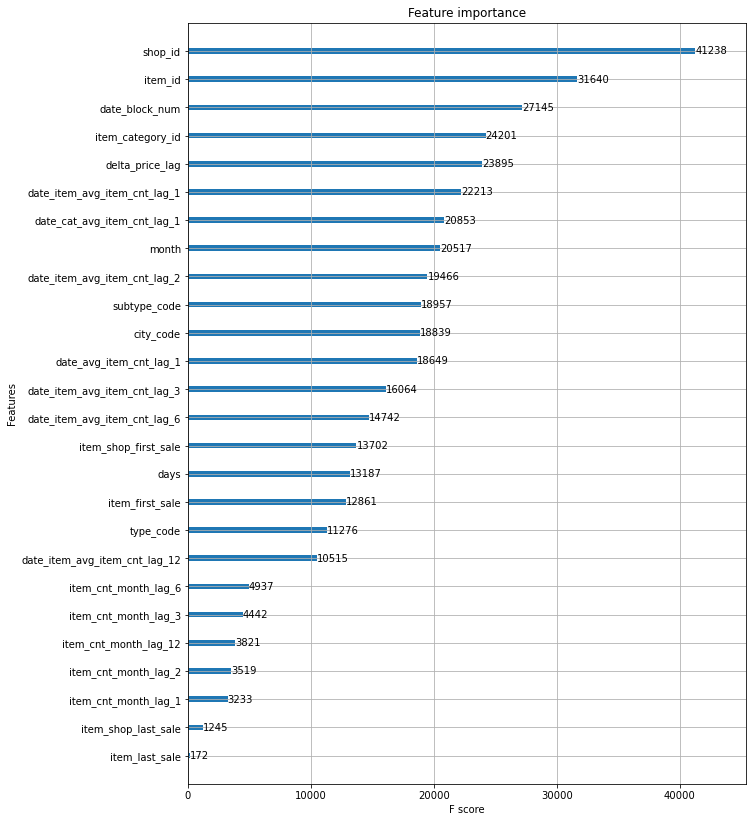

In [88]:
plot_features(clf, (10,14))

### ② 최종 제출 모델 :: LGBRegressor

In [93]:
import lightgbm as lgb

In [89]:
def build_lgb_model(params, X_train, X_val, y_train, y_val, cat_features):
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val)
    model = lgb.train(params=params, train_set=lgb_train, valid_sets=(lgb_train, lgb_val), verbose_eval=50,
                     categorical_feature=cat_features)
    return model

In [ ]:
{'lambda_l1': 0.0003107507719222102,
 'lambda_l2': 0.6646083396957045,
 'num_leaves': 1458,
 'feature_fraction': 0.5806154804111331,
 'learning_rate': 0.02789273649891212,
 'bagging_freq': 1,
 'min_child_samples': 20}

In [90]:
params = {
    'objective': 'rmse',
    'metric': 'rmse',
    'num_leaves': 1023,
    'min_data_in_leaf':10,
    'feature_fraction':0.7,
    'learning_rate': 0.01,
    'num_rounds': 1000,
    'early_stopping_rounds': 30,
    'seed': 1
}

In [91]:
cat_features = ['item_category_id','month','date_item_avg_item_cnt_lag_1','delta_price_lag']

In [94]:
lgb_model = build_lgb_model(params, X_train, X_valid, Y_train, Y_valid, cat_features)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.170949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2071
[LightGBM] [Info] Number of data points in the train set: 6186922, number of used features: 26
[LightGBM] [Info] Start training from score 0.288852
Training until validation scores don't improve for 30 rounds
[50]	training's rmse: 0.963827	valid_1's rmse: 0.991633
[100]	training's rmse: 0.848131	valid_1's rmse: 0.935631
[150]	training's rmse: 0.786804	valid_1's rmse: 0.916555
[200]	training's rmse: 0.751856	valid_1's rmse: 0.9109
Early stopping, best iteration is:
[213]	training's rmse: 0.74527	valid_1's rmse: 0.9103


In [95]:
submission = pd.read_csv('./data/sample_submission.csv')
submission['item_cnt_month'] = lgb_model.predict(X_test).clip(0,20)
submission[['ID', 'item_cnt_month']].to_csv('lgb_submission_RMSE_91030.csv', index=False)

## Result of Project    

#### Good Point   
* 다양한 도메인을 가지고 있는 팀원들과 데이터 분석 과정에서 함께 고민하며 많은 인사이트를 얻을 수 있었다.    
* 정형 데이터 / 시계열 데이터를 활용한 프로젝트를 경험하며 Sequence Data 특성에 대하여 다시 한번 학습할 수 있었고, 그렇기 때문에 데이터 전처리 과정에서 유의해야 할 사항을 알게 되었다.    
* 시계열 데이터에 적합한 api 라이브러리를 분석 도구로 활용하였고, 새로운 분석과 시각화 기법을 시도하였다.     
* 다양한 모델을 생성하고 학습하고 최적화 하는 과정에서 모델 구조와 기법에 대하여 적용하였다.

#### Difficulties    
* 시계열 데이터에서 중요한 이전 데이터의 흐름이 중요하게 작용한다는 점을 유의하며 데이터 가공을 하는 것이 중요했다.   
* 시계열 데이터의 특성 상 이전 데이터와의 연관성 때문에 랜덤하게 데이터를 뽑아서 사용하면 안된다.     
* 모델 최적화 과정에서 얻은 score 값이 좋다고 실제 test 결과에 높은 score가 나오지는 않았는데, 이는 여러가지 이유가 있을 것 같다.    
    - 데이터 전처리/가공 과정에서 Feature Engineering의 부족   
    - Test Data에는 있는 아이템(상품)의 종류가 Train Data에는 없었기 때문에 Test score가 높게 나올 수가 없다.   
    